# **PYTORCH DRAWED NUMBERS IMAGE DETECTION**

#ABSTRACT

Este proyecto busca crear un modelo de red neuronal, capaz de detectar numeros a partir de imagenes de numeros realizadas con un programa de dibujo. Para ello se utiliza el framework Pytorch. Utilizando diferentes herramientas para crear un modelo de CNN (Convolutional neural network) simple, liviano y rapido pero lo suficientemente efectivo para realizar la tarea.

#PREPARACIÓN ENTORNO

Importación e instalación de librerias.

In [ ]:
import torch
from torch import nn
from torch.utils.data import Dataset

import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor
from torchvision.transforms import v2

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from typing import Tuple, Dict, List

import pathlib
from pathlib import Path

import random
from PIL import Image

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from pathlib import Path

from timeit import default_timer as timer

from tqdm.auto import tqdm

from pathlib import Path

import os
import requests
import zipfile

print(torch.__version__)
print(torchvision.__version__)

2.1.0+cu121
0.16.0+cu121


In [ ]:
try:
    from torchmetrics import Accuracy
except:
    !pip install torchmetrics
    import torchmetrics
    from torchmetrics import Accuracy

In [ ]:
try:
    from torchinfo import summary
except:
    !pip install torchinfo
    import torchinfo
    from torchinfo import summary

In [ ]:
try:
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")
    assert int(mlxtend.__version__.split(".")[1]) >= 19, "mlxtend verison should be 0.19.0 or higher"
except:
    !pip install -q torchmetrics -U mlxtend # <- Note: If you're using Google Colab, this may require restarting the runtime
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")

mlxtend version: 0.22.0


In [ ]:
import mlxtend
print(mlxtend.__version__)
assert int(mlxtend.__version__.split(".")[1]) >= 19

0.22.0


In [ ]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

#OBTENCIÓN DE IMAGENES

Para poder entrenar y testear el modelo usaremos el dataset MNIST. El cual tiene 60000 imagenes para entrenamiento y 10000 para testeo. Las cuales estan ya etiquetadas.

In [ ]:
train_data = torchvision.datasets.MNIST(root= "data", #Where to download data to?
                                  train = True, #Train dataset? -> True
                                  transform = torchvision.transforms.ToTensor(), #Apply any transformation? We transform to tensor
                                  target_transform = None, #Tranform labels target?
                                  download = True
)

test_data = datasets.MNIST(root= "data",
                                  train = False, #Train dataset? -> False
                                  transform = torchvision.transforms.ToTensor(), #Apply any transformation? We transform to tensor
                                  target_transform = None,
                                  download = True
)

Como prueba adicional y finalidad de este proyecto. Se intentara detectar que numeros representan las imagenes creadas usando un programa de dibujo. En este caso se dibujaron diferentes numeros usando Paint y se guardaron estas imagenes en carpetas. Por fines practicos esta carpeta se encuetra compromida en un repositorio de github por lo que se debe descargar y descomprimir.

El link al respositorio: https://github.com/Andresmup/ArchivosDataScience/raw/main/custom_images.zip

In [ ]:
#Copy custom images from "https://github.com/Andresmup/ArchivosDataScience/raw/main/custom_images.zip"

data_path = Path("data/")
custom_image_path = data_path / "custom_images"


# If the image folder doesn't exist, download it and prepare it...
if custom_image_path.is_dir():
    print(f"{custom_image_path} directory exists.")
else:
    print(f"Did not find {custom_image_path} directory, creating one...")
    custom_image_path.mkdir(parents=True, exist_ok=True)

    # Download custom numbers images
    with open(data_path / "custom_images.zip", "wb") as f:
        request = requests.get("https://github.com/Andresmup/ArchivosDataScience/raw/main/custom_images.zip")
        print("Downloading custom numbers images...")
        f.write(request.content)

    # Unzip custom numbers images
    with zipfile.ZipFile(data_path / "custom_images.zip", "r") as zip_ref:
        print("Unzipping custom numbers images...")
        zip_ref.extractall(data_path)


data/custom_images directory exists.


#ANÁLISIS EXPLORATORIO DE DATOS (EDA)

A continuación se visualizara una imagen del dataset MNIST, ademas de conocer cual es tamaño de dichas imagenes; las cuales son de 28x28, por lo que mas adelante se usara dicho valor.

In [ ]:
#Separe image from label
image, label = train_data[0]
#Show size
image.size()

torch.Size([1, 28, 28])

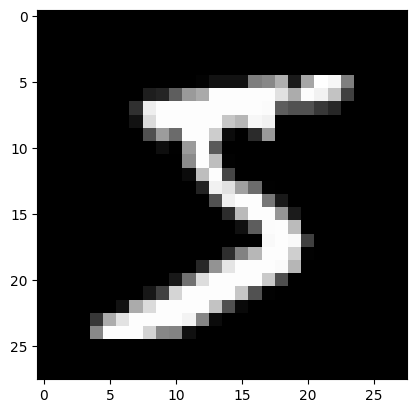

In [ ]:
#Show image, permutation need tensors are [color_channels, height, width] -> matplotlib use [height, width, color_channels]
plt.imshow(image.permute(1, 2, 0), cmap="gray")

Por otro lado es importante saber cuales son las etiquetas de las imagenes. Por lo que se revisan.

In [ ]:
class_names = train_data.classes
class_names

['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine']

Ademas conocer sus repectivos indices, en este caso corresponden a su numeración. Es decir, hay 10 etiquetas o clases posibles, del 0 al 9 cada una representa el numero que es dicha imagen.

In [ ]:
class_with_index= train_data.class_to_idx
class_with_index

{'0 - zero': 0,
 '1 - one': 1,
 '2 - two': 2,
 '3 - three': 3,
 '4 - four': 4,
 '5 - five': 5,
 '6 - six': 6,
 '7 - seven': 7,
 '8 - eight': 8,
 '9 - nine': 9}

A continuación se grafican 16 imagenes aleatorias del dataset con sus respectivas etiquetas y tamaño. Como parte a destacar se debe recordar que los tensores estan guardados con la estructura (c, h, w), es decir, canal del color, alto y ancho. Mientras que para gráficar una imagen con matplotlib se debe usar el orden (h, w, c); por lo que se debera permutar el orden del tensor para esto.

In [ ]:
#1. Create a function to take in a sample from the dataset
def display_random_images(dataset: torch.utils.data.Dataset,
                          classes: List[str] = None,
                          display_shape: bool = True,
                          seed: int = None):
  '''

  Function to display a random selection of images from a PyTorch dataset.
  The function plots a 4x4 grid of randomly chosen samples, with optional class labels and image shape information.
  Parameters:
  - dataset: PyTorch dataset containing the image data.
  - classes: List of class names (optional) for displaying class labels.
  - display_shape: Boolean indicating whether to display the shape of each image tensor (default is True).
  - seed: Optional seed for reproducibility in randomly selecting samples.
  Example:
  - display_random_images(my_dataset, classes=my_class_names, display_shape=True, seed=42)

  '''
  #2. Plot 4 by 4
  rows, cols = 4, 4
  n = 16
  seed = 42
  # 3. Set random seed
  if seed:
    random.seed(seed)
  # 4. Get random sample indexes
  random_samples_idx = random.sample(range(len(dataset)), k=n)
  #5. Setup plot
  plt.figure(figsize=(16,8))
  # 6. Loop through samples and display random samples
  for i, targ_sample in enumerate(random_samples_idx):
    # All the samples in our targ_sample are in tuples
    targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

    # Adjust image tensor shape for plotting: [color_channels, height, width] -> [height, width, color_channels]
    targ_image_adjust = targ_image.permute(1, 2, 0)

    # Plot adjusted samples
    plt.subplot(rows, cols, i + 1)
    plt.imshow(targ_image_adjust, cmap="gray")
    plt.axis("off")
    if classes:
      title = f"class: {classes[targ_label]}"
      # Optionally display the shape of the image tensor
      if display_shape:
        title = title + f"\nshape: {targ_image_adjust.shape}"
        plt.title(title)

  plt.tight_layout()
  plt.show()

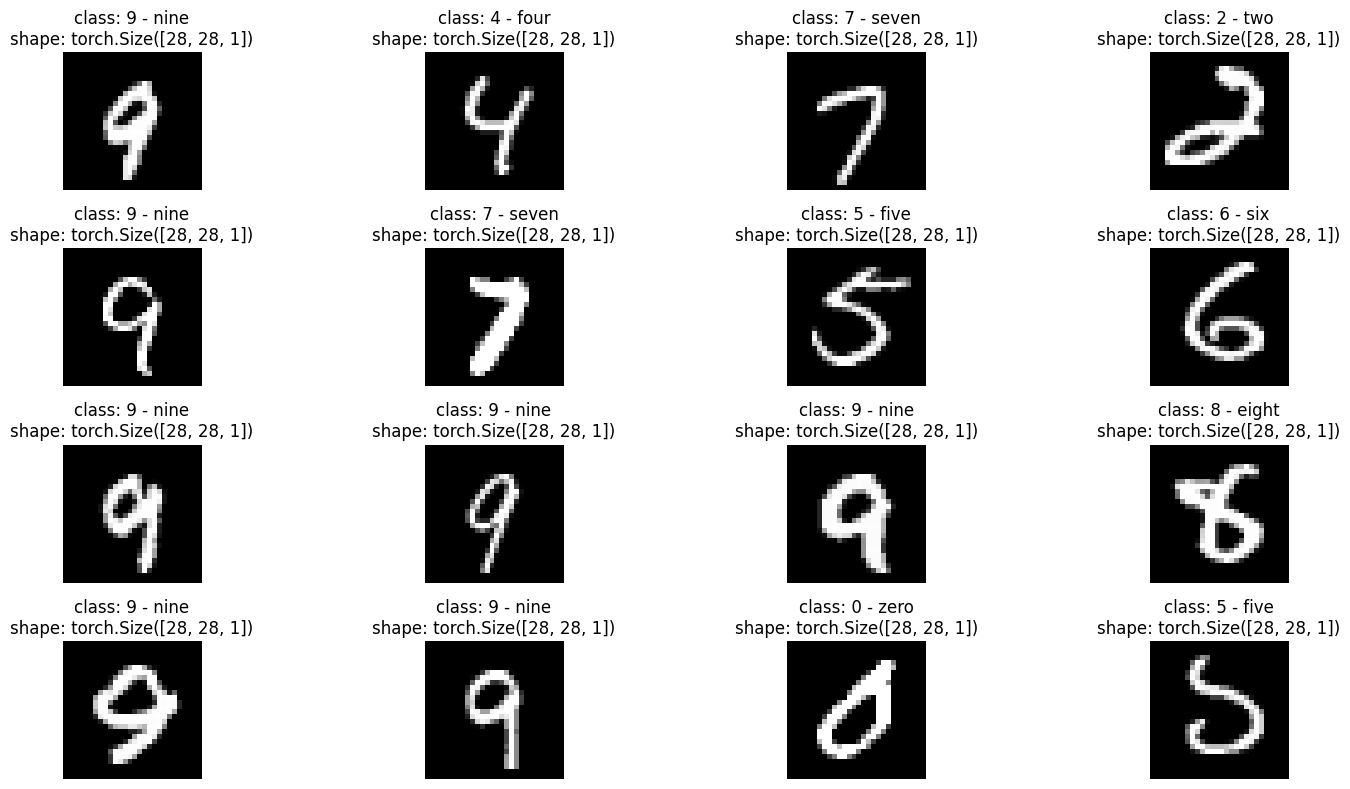

In [ ]:
#Plot random images
display_random_images(train_data,
                      classes=class_names,
                      seed=42)

#PREPARACIÓN DE DATOS PARA ENTRENAMIENTO Y TEST

Para poder realizar el entrenamiento y testeo; se utilizara un sistema de lotes. El cual mejora el rendimiento y la velocidad; ademas evitara que se sature la memoria. Ya que en este caso cada lote tendra 32 imagenes como máximo, lo cual no supondra un problema para ningun hardware.

In [ ]:
#Define batch size
BATCH_SIZE = 32

#Define train and test dataloader
train_dataloader = torch.utils.data.DataLoader(dataset = train_data, batch_size=BATCH_SIZE,shuffle = True) #We want to shuffle the train data.
test_dataloader = torch.utils.data.DataLoader(dataset = test_data, batch_size=BATCH_SIZE,shuffle = np.False_)

#CREACIÓN MODELO

Al utilizar CUDA con PyTorch, se puede aprovechar las GPU compatibles con CUDA para acelerar significativamente el entrenamiento y la inferencia de modelos de aprendizaje profundo. Por lo se define a cuda como dispositivo en caso de estar disponible.

In [ ]:
#Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

Para este proyecto se utiliza un mini version de la arquitectura VGG. La cual se divide en dos partes principales:
* Una sección de feature extraction que en este caso es de dos bloques. Cada uno consta de 2 Conv2d layers, intercalados con funciones ReLU y MaxPool2d.
* Sección classifier, esta consta de un modulo Linear predecido de uno Flatten.

In [ ]:
class TinyVGGV0(nn.Module):
  '''
  Definition of a TinyVGGV0 neural network model using PyTorch's nn.Module.
  This model consists of two convolutional blocks for feature extraction followed by a classifier layer.
  Parameters:
   - input_shape: Number of input channels (e.g., 3 for RGB images).
   - hidden_units: Number of channels in the convolutional layers.
   - output_shape: Number of output classes.
  Architecture:
   - 1st Convolutional Block (FEATURE EXTRACTOR):
       - Two Conv2d layers with ReLU activation followed by MaxPool2d layer.
   - 2nd Convolutional Block (FEATURE EXTRACTOR):
       - Two Conv2d layers with ReLU activation followed by MaxPool2d layer.
   - Classifier Block:
       - Flatten the output into a single feature vector.
       - Linear layer mapping to the output shape.
  Forward Method:
   - Applies the convolutional blocks and classifier sequentially to the input.
  Example:
   - model = TinyVGGV0(input_shape=3, hidden_units=64, output_shape=10)
   - output = model(input_tensor)
  '''
  def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        #Create 1st convolutional block -> FEATURE EXTRACTER
        self.conv_block_1 = nn.Sequential(
            #Conv2d for 2d data (images)
            nn.Conv2d(in_channels=input_shape, #same as input shape before
                      out_channels=hidden_units, #same as output shape before
                      kernel_size=3, #Hiperparameter the most commonly used approach is zero-padding because of its performance, simplicity, and computational efficiency.
                                    #Relation bewteen input_shape and output_shape per sub divition. k=1 6x6->6x6; k=2 6x6->5x5
                      stride=1, #Hiperparameter controls the stride for the cross-correlation, a single number or a tuple
                                #The impact stride has on a CNN is similar to kernel size. As stride is decreased, more features are learned because more data is extracted, which also leads to larger output layers. On the contrary, as stride is increased, this leads to more limited feature extraction and smaller output layer dimensions.
                      padding=0), #Hiperparameter / Value of the padding -> Padding conserves data at the borders of activation maps, which leads to better performance, and it can help preserve the input's spatial size, which allows an architecture designer to build deeper, higher performing networks
                                  #the most commonly used approach is zero-padding because of its performance, simplicity, and computational efficiency.
            nn.ReLU(), #Add relu layer
            #Add another conv2d layer with the input equal to the hidden units. In this case same hiperparameters
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=0),
            nn.ReLU(), #Add relu layer
            nn.MaxPool2d(kernel_size=2)) #Add MaxPool2d layer takes the max from the imput matrix and return the max of all those. Reduce the output shape into half (60,60) -> (30,30)
        #Create 2st convolutional block -> FEATURE EXTRACTER
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=0),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2))
        #Create last block, classifies block -> CLASSIFIER LAYER, TAKE THE FEATURES AND SET THE INTO THE OUTPUT LABELS
        self.classifier = nn.Sequential(
            nn.Flatten(), #Flatten the output into a single feature vector
            nn.Linear(in_features=hidden_units*4*4, #multiplication for 16 to match dimension
                      out_features=output_shape),
            )

  def forward(self, x): #x -> conv_block_1 -> conv_block_2 -> classifier -> return(x)
    return self.classifier(self.conv_block_2(self.conv_block_1(x)))

Este modelo consta usar input shape 1, esto es debido a que las imagenes son en blanco y negro por lo que el canal de color es 1.
Se usara un numero de hidden units 16, ya que permitira buena precisión sin ralentizar el algoritmo.
Por ultimo se define como el output shape al tamaño o numero de clases que hay para nuestro dataset. El cual es 10, ya que va del 0 al 9.

In [ ]:
#Set seed
torch.manual_seed(45)
#instantiate the tinyvgg model
model_0 = TinyVGGV0(input_shape=1, #number of color channels in our image data
                    hidden_units=16, #number of hidden units
                    output_shape=len(class_names) #number of outputs
                    ).to(device) #send to device

A continuación podemos se observa la cantidad de parametros y tamaño para cada una de las secciones.
El tamaño del modelo es de 0.22Mb por lo que cumple con la premisa de tamaño reducido.

In [ ]:
#See sumary, input size must be equal to actual input size
summary(model_0, input_size=(1, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGGV0                                [1, 10]                   --
├─Sequential: 1-1                        [1, 16, 12, 12]           --
│    └─Conv2d: 2-1                       [1, 16, 26, 26]           160
│    └─ReLU: 2-2                         [1, 16, 26, 26]           --
│    └─Conv2d: 2-3                       [1, 16, 24, 24]           2,320
│    └─ReLU: 2-4                         [1, 16, 24, 24]           --
│    └─MaxPool2d: 2-5                    [1, 16, 12, 12]           --
├─Sequential: 1-2                        [1, 16, 4, 4]             --
│    └─Conv2d: 2-6                       [1, 16, 10, 10]           2,320
│    └─ReLU: 2-7                         [1, 16, 10, 10]           --
│    └─Conv2d: 2-8                       [1, 16, 8, 8]             2,320
│    └─ReLU: 2-9                         [1, 16, 8, 8]             --
│    └─MaxPool2d: 2-10                   [1, 16, 4, 4]             --
├─Seq

#TRAIN AND TEST MODELO

Se definen dos funciones, cada una para la etapa de entrenamiento y testeo del modelo. Dichas funciones retornaran la perdida (loss) y la exactitud (accuracy).

In [ ]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):
  '''
  Function to perform a training step for a PyTorch model.
  This function executes a single training iteration on the provided data using the specified loss function and optimizer.
  Parameters:
    - model: PyTorch neural network model.
    - dataloader: PyTorch DataLoader providing the training data.
    - loss_fn: PyTorch loss function to calculate the training loss.
    - optimizer: PyTorch optimizer for updating model parameters.
  Behavior:
    - Puts the model in train mode.
    - Iterates through batches in the dataloader:
      1. Performs a forward pass to obtain predictions.
      2. Calculates and accumulates the loss.
      3. Zeroes the gradients, performs backward pass, and updates model parameters.
      4. Accumulates accuracy metric.
    - Calculates average loss and accuracy per batch.
  Returns:
    - Tuple containing the average training loss and accuracy.
  Example:
    train_loss, train_acc = train_step(my_model, train_dataloader, my_loss_function, my_optimizer)
  '''
    # Put model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0

    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

In [ ]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module):
  '''
  Function to perform a testing step for a PyTorch model.
  This function evaluates the model's performance on the provided test data using the specified loss function.
  Parameters:
    - model: PyTorch neural network model.
    - dataloader: PyTorch DataLoader providing the test data.
    - loss_fn: PyTorch loss function to calculate the test loss.
  Behavior:
    - Puts the model in evaluation (eval) mode.
    - Iterates through batches in the dataloader:
      1. Performs a forward pass to obtain predictions.
      2. Calculates and accumulates the loss.
      3. Calculates and accumulates accuracy.
    - Calculates average loss and accuracy per batch.
  Returns:
    - Tuple containing the average test loss and accuracy.
  Example:
    test_loss, test_acc = test_step(my_model, test_dataloader, my_loss_function)
  '''

    # Put model in eval mode
    model.eval()
    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
          # Send data to target device
          X, y = X.to(device), y.to(device)

          # 1. Forward pass
          test_pred_logits = model(X)


          # 2. Calculate and accumulate loss
          loss = loss_fn(test_pred_logits, y)
          test_loss += loss.item()

          # Calculate and accumulate accuracy
          test_pred_labels = test_pred_logits.argmax(dim=1)
          test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    # Adjust metrics to get average loss and accuracy per batch
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

Se define una funcion entrenamiento. Esta función imprimira la función de perdida y la exactitud del proceso. Lo cual permite poder realizar un analisis de nuestro modelo para cada una de las pasadas de nuestro modelo.

In [ ]:
#1. Define function
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):
  '''
  Function to train a PyTorch neural network model over a specified number of epochs.
  This function performs training and testing steps, updating the model parameters, and collecting performance metrics.
  Parameters:
    - model: PyTorch neural network model to be trained.
    - train_dataloader: PyTorch DataLoader providing the training data.
    - test_dataloader: PyTorch DataLoader providing the test data.
    - optimizer: PyTorch optimizer for updating model parameters.
    - loss_fn: PyTorch loss function to calculate both training and test losses (default is CrossEntropyLoss).
    - epochs: Number of training epochs (default is 5).
  Returns:
    - Dictionary containing lists of training and test losses, as well as training and test accuracies at each epoch.
  Example:
    training_results = train(my_model, train_dataloader, test_dataloader, my_optimizer, my_loss_function, epochs=10)
  '''
    # 2. Create empty results dictionary
    results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }

    # 3. Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        test_loss, test_acc = test_step(model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn)

        # 4. Print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        # 5. Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    # 6. Return the filled results at the end of the epochs
    return results

Para este caso se realizan 10 pasadas. Ademas se incluye un conteo del tiempo para poder realizar un analis de la velocidad.

In [ ]:
# Set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 10

# Recreate an instance of TinyVGG
model_0 = TinyVGGV0(input_shape=1, # number of color channels (1 for black and white)
                  hidden_units=16, # hidden units
                  output_shape=len(train_data.classes)).to(device) #number of classes in this case is 10

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()

# Setup optimizer, we use Adam
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.001)

# Start the timer
start_time = timer()

# Train model_0
model_0_results_E5 = train(model=model_0,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.2245 | train_acc: 0.9291 | test_loss: 0.0699 | test_acc: 0.9774
Epoch: 2 | train_loss: 0.0726 | train_acc: 0.9771 | test_loss: 0.0534 | test_acc: 0.9829
Epoch: 3 | train_loss: 0.0537 | train_acc: 0.9831 | test_loss: 0.0442 | test_acc: 0.9862
Epoch: 4 | train_loss: 0.0429 | train_acc: 0.9868 | test_loss: 0.0373 | test_acc: 0.9877
Epoch: 5 | train_loss: 0.0378 | train_acc: 0.9881 | test_loss: 0.0353 | test_acc: 0.9883
Epoch: 6 | train_loss: 0.0316 | train_acc: 0.9899 | test_loss: 0.0428 | test_acc: 0.9857
Epoch: 7 | train_loss: 0.0286 | train_acc: 0.9907 | test_loss: 0.0347 | test_acc: 0.9890
Epoch: 8 | train_loss: 0.0258 | train_acc: 0.9917 | test_loss: 0.0319 | test_acc: 0.9893
Epoch: 9 | train_loss: 0.0228 | train_acc: 0.9925 | test_loss: 0.0335 | test_acc: 0.9887
Epoch: 10 | train_loss: 0.0209 | train_acc: 0.9932 | test_loss: 0.0331 | test_acc: 0.9893
Total training time: 155.075 seconds


En este caso el modelo TinyVGG es capaz de obtener valores de loss muy bajos, y un accuracy bastante bueno.
Tanto en la sección de imagenes de entrenamiento como en la de testeo. Se observa que cada una de las pasadas fue mejorando dichos valores.
Ademas el dicha tarea tardó solo 155 segundos, lo cual es un tiempo aceptable considerando que esta se realizó en google colab utilizando un gpu T4.

#PREDICCIÓN MINI SET ALEATORIO

Una vez entrenado nuestro modelo se realiza una prueba de predicción utilizando imagenes aleatorias del dataset MNIST. Para esto se crea una función make_predictions.

In [ ]:
def make_predictions(model: torch.nn.Module, data: list, device: torch.device = device):

  '''
  Function to make predictions using a trained PyTorch neural network model on a given set of data.
  This function takes a list of data samples, performs inference using the model, and returns the predicted probabilities.
  Parameters:
    - model: PyTorch neural network model for making predictions.
    - data: List of data samples to be used for prediction.
    - device: PyTorch device where the model should perform inference (default is the device the model is currently on).
  Returns:
    - Tensor containing the predicted probabilities for each class for each input sample.
  Example:
    predictions = make_predictions(my_model, my_data)
  '''
    pred_probs = []
    model.eval()
    with torch.inference_mode():
        for sample in data:
            # Prepare sample
            sample = torch.unsqueeze(sample, dim=0).to(device) # Add an extra dimension and send sample to device

            # Forward pass (model outputs raw logit)
            pred_logit = model(sample)

            # Get prediction probability (logit -> prediction probability)
            pred_prob = torch.softmax(pred_logit.squeeze(), dim=0) # note: perform softmax on the "logits" dimension, not "batch" dimension (in this case we have a batch size of 1, so can perform on dim=0)

            # Get pred_prob off GPU for further calculations
            pred_probs.append(pred_prob.cpu())

    # Stack the pred_probs to turn list into a tensor
    return torch.stack(pred_probs)

Se extraen 9 imagenes aleatorias con sus correspondientes etiquetas.

In [ ]:
#Set seed
random.seed(45)
#Create empty list for samples and labels
random_samples = []
random_labels = []
#Get the random data using for loop
for sample, label in random.sample(list(test_data), k=9):
    random_samples.append(sample)
    random_labels.append(label)

In [ ]:
#Make predictions
random_pred_probs= make_predictions(model=model_0,
                             data=random_samples)

#Transform prediction probabilities -> predictions labels using argmax
random_pred_classes = random_pred_probs.argmax(dim=1)

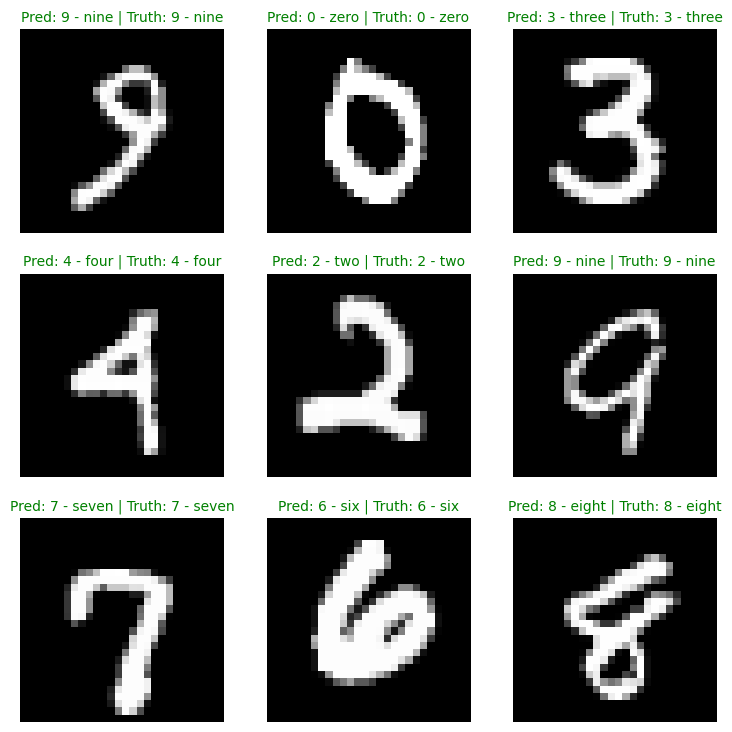

In [ ]:
# Plot predictions
plt.figure(figsize=(9, 9))
nrows = 3
ncols = 3
for i, sample in enumerate(random_samples):
  # Create a subplot
  plt.subplot(nrows, ncols, i+1)

  # Plot the target image
  plt.imshow(sample.squeeze(), cmap="gray")

  # Find the prediction label (in text form, e.g. "Sandal")
  pred_label = class_names[random_pred_classes[i]]

  # Get the truth label (in text form, e.g. "T-shirt")
  truth_label = class_names[random_labels[i]]

  # Create the title text of the plot
  title_text = f"Pred: {pred_label} | Truth: {truth_label}"

  # Check for equality and change title colour accordingly
  if pred_label == truth_label:
      plt.title(title_text, fontsize=10, c="g") # green text if correct
  else:
      plt.title(title_text, fontsize=10, c="r") # red text if wrong
  plt.axis(False);

Como se observa el model fue capaz de predecir con exactitud que números representaban cada una de las imagenes.

#VISUALIZACIÓN IMAGEN CUSTOM FOLDER

En esta segunda parte del proyecto se pone el modelo a prueba contra imagenes que no forman parte del dataset MNIST.
Primeramente se realiza una visualización para poder conocer como es el formato, tamaño y otras caracteristicas de las imagenes de números dibujadas descargadas.

In [ ]:
# Set seed
random.seed(42)

# 1. Get all image paths (* means "any combination")
custom_image_path_list = list(custom_image_path.glob("*/*.jpg"))

# 2. Get random image path
custom_random_image_path = random.choice(custom_image_path_list)

# 3. Get image class from path name (the image class is the name of the directory where the image is stored)
custom_image_class = custom_random_image_path.parent.stem

Random image path: data/custom_images/8 - eight/8-0004.jpg
Image class: 8 - eight
Image height: 648
Image width: 1152


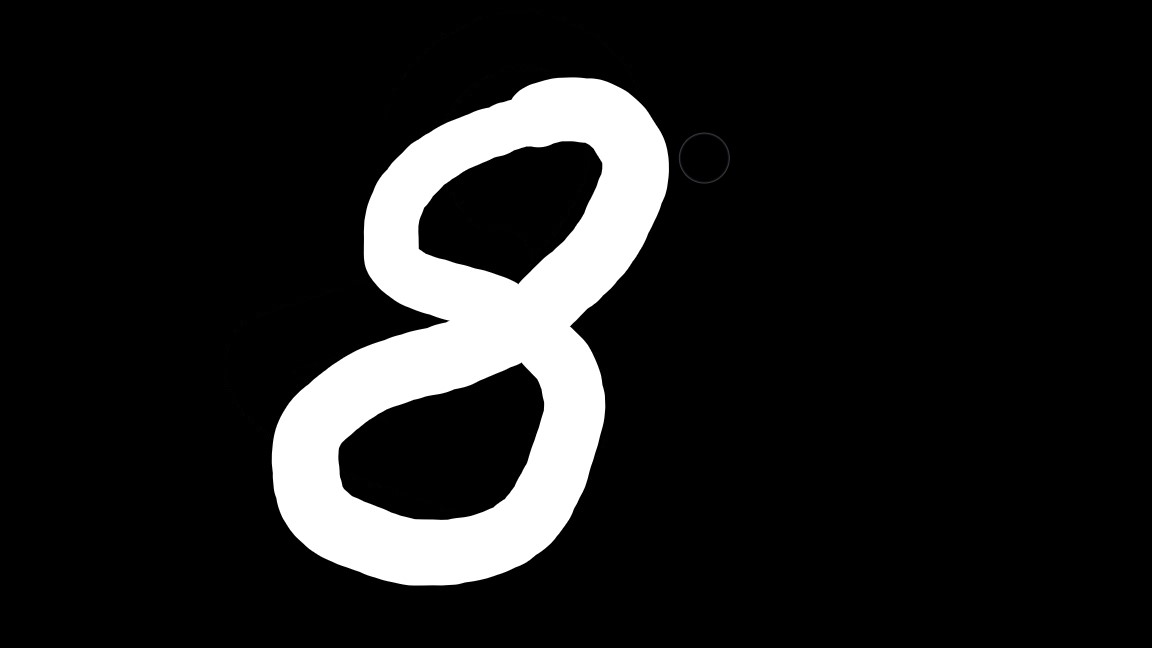

In [ ]:
# 4. Open image
img = Image.open(custom_random_image_path)

# 5. Print metadata
print(f"Random image path: {custom_random_image_path}")
print(f"Image class: {custom_image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
#Plot image
img

Se observa que las imagenes tienen un tamaño diferente al del dataset MNIST. Por lo que se debera realizar un trabajo de pre procesado con las mismas.

#REVISIÓN DATOS EN PATH

Para comprender como estan almacenadas se revisa como estan guardadas.

In [ ]:
def walk_through_dir(dir_path):
  """
  Walks through dir_path returning its contents.
  Args:
    dir_path (str or pathlib.Path): target directory

  Returns:
    A print out of:
      number of subdiretories in dir_path
      number of images (files) in each subdirectory
      name of each subdirectory
  """
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [ ]:
#Applies walk_trough_dir function to path
walk_through_dir(data_path)

There are 2 directories and 1 images in 'data'.
There are 1 directories and 0 images in 'data/MNIST'.
There are 0 directories and 8 images in 'data/MNIST/raw'.
There are 10 directories and 0 images in 'data/custom_images'.
There are 0 directories and 5 images in 'data/custom_images/7 - seven'.
There are 0 directories and 5 images in 'data/custom_images/5 - five'.
There are 0 directories and 5 images in 'data/custom_images/4 - four'.
There are 0 directories and 5 images in 'data/custom_images/3 - three'.
There are 0 directories and 5 images in 'data/custom_images/2 - two'.
There are 0 directories and 5 images in 'data/custom_images/1 - one'.
There are 0 directories and 5 images in 'data/custom_images/6 - six'.
There are 0 directories and 5 images in 'data/custom_images/9 - nine'.
There are 0 directories and 5 images in 'data/custom_images/8 - eight'.
There are 0 directories and 5 images in 'data/custom_images/0 - zero'.


Se puede observar que las carpetas que contienen las imagenes son a su vez la clase de estas.

#TRANSFORMACION A REALIZAR EN CUSTOM DATA

Para realizar el pre procesado de las imagenes se tranforman a tensores y se normalizan. Ademas se deben reescalar a un tamaño de 28x28. Tambien se deben transformar a una escala de gris y mostrar con un canal de color de 1.
Para que coincidan con las imagenes usadas para el entrenamiento y testeo; es decir, para poder ser utilizadas por el modelo.

In [ ]:
#Transformation to tensor, resize, grayscale and normalize
custom_data_transform = v2.Compose([
    v2.ToImage(),  # Convert to tensor, only needed if you had a PIL image
    v2.ToDtype(torch.uint8, scale=True),  # optional, most input are already uint8 at this point
    v2.Resize(size=(28, 28), antialias=True), #Resize to 28x28
    v2.ToDtype(torch.float32, scale=True),  # Normalize expects float input
    v2.ToTensor(), #Tranform to tensor
    v2.Normalize([0, 0, 0], [1, 1, 1]), #Normalize
    v2.Grayscale(num_output_channels=1) #Set to grayscale with only one color channel
])


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


In [ ]:
#Applies tranformation
custom_image_data = datasets.ImageFolder(root = custom_image_path,
                                         transform = custom_data_transform, #Transform for the data
                                         target_transform = None)

#VISUALIZACIÓN IMAGENES TRANSFORMADAS

Se realiza la visualización de la misma imagen que antes pero una vez tranformada en tensor y adaptada para el modelo TinyVGG pueda realizar una predicción sobre esta.

In [ ]:
custom_class_names = custom_image_data.classes

In [ ]:
#Define seed
random.seed(42)
#Create samples and labels list
test_samples = []
test_labels = []
for sample, label in random.sample(list(custom_image_data), k=9):
    test_samples.append(sample)
    test_labels.append(label)

# View the first test sample shape and label
print(f"Test sample label: {test_labels[0]} ({custom_class_names[test_labels[0]]})")

Test sample label: 8 (8 - eight)


Text(0.5, 1.0, '8 - eight')

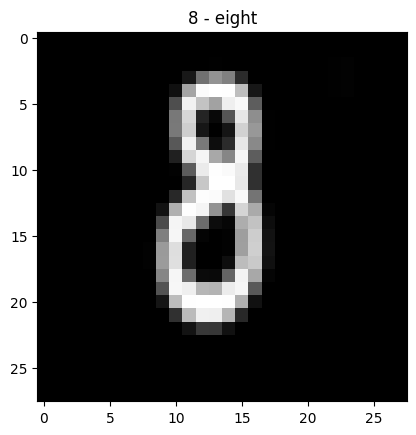

In [ ]:
#Show image, permutation need tensors are [color_channels, height, width] -> matplotlib use [height, width, color_channels]
plt.imshow(test_samples[0].permute(1,2,0),cmap="gray")
#Set title equal to it's class
plt.title(custom_class_names[test_labels[0]])

#CREACIÓN CUSTOM DATASET A PARTIR DE CARPETA CON IMAGENES

Se define un nuevo dataset. El cual contiene las imagenes descargadas pero tranformadas aplicando lo definido anteriormente. Ademas este dataset contendra las clases de dichas imagenes a partir de la carpeta donde se encuentran guardadas.

In [ ]:
# Setup path for target directory
custom_target_directory = custom_image_path
print(f"Target directory: {custom_target_directory}")

# Get the class names from the target directory
custom_class_names_found = sorted([entry.name for entry in list(os.scandir(custom_target_directory))])
print(f"Class names found: {custom_class_names_found}")

Target directory: data/custom_images
Class names found: ['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']


Se definen funciones para la implementación.

In [ ]:
# Make function to find classes in target directory
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
    """Finds the class folder names in a target directory.

    Assumes target directory is in standard image classification format.

    Args:
        directory (str): target directory to load classnames from.

    Returns:
        Tuple[List[str], Dict[str, int]]: (list_of_class_names, dict(class_name: idx...))
    """
    # 1. Get the class names by scanning the target directory
    classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())

    # 2. Raise an error if class names not found
    if not classes:
        raise FileNotFoundError(f"Couldn't find any classes in {directory}.")

    # 3. Create a dictionary of index labels (computers prefer numerical rather than string labels)
    class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
    return classes, class_to_idx

In [ ]:
# 1. Subclass torch.utils.data.Dataset
class ImageFolderCustom(Dataset):
    '''
    Subclass of torch.utils.data.Dataset for creating a custom image dataset.
    This class allows easy loading and transformation of image data.
    Parameters:
    - targ_dir: Path to the target directory containing class subdirectories with image files.
    - transform: Optional data transformation to be applied to the images (default is None).
    Attributes:
    - paths: List of pathlib.Path objects representing the paths to all image files.
    - transform: Data transformation function.
    - classes: List of class names.
    - class_to_idx: Dictionary mapping class names to their corresponding indices.
    Methods:
    - load_image(index): Loads an image at the specified index using its path.
    - __len__(): Returns the total number of samples in the dataset.
    - __getitem__(index): Returns one sample of data as a tuple (X, y), where X is the image data and y is the class index.
    Example:
      custom_dataset = ImageFolderCustom(targ_dir="path/to/data", transform=my_transform)
      sample = custom_dataset[0]
    '''
    # 2. Initialize with a targ_dir and transform (optional) parameter
    def __init__(self, targ_dir: str, transform=None) -> None:

        # 3. Create class attributes
        # Get all image paths
        self.paths = list(pathlib.Path(targ_dir).glob("*/*.jpg")) # note: you'd have to update this if you've got .png's or .jpeg's
        # Setup transforms
        self.transform = transform
        # Create classes and class_to_idx attributes
        self.classes, self.class_to_idx = find_classes(targ_dir)

    # 4. Make function to load images
    def load_image(self, index: int) -> Image.Image:
        "Opens an image via a path and returns it."
        image_path = self.paths[index]
        return Image.open(image_path)

    # 5. Overwrite the __len__() method (optional but recommended for subclasses of torch.utils.data.Dataset)
    def __len__(self) -> int:
        "Returns the total number of samples."
        return len(self.paths)

    # 6. Overwrite the __getitem__() method (required for subclasses of torch.utils.data.Dataset)
    def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
        "Returns one sample of data, data and label (X, y)."
        img = self.load_image(index)
        class_name  = self.paths[index].parent.name # expects path in data_folder/class_name/image.jpeg
        class_idx = self.class_to_idx[class_name]

        # Transform if necessary
        if self.transform:
            return self.transform(img), class_idx # return data, label (X, y)
        else:
            return img, class_idx # return data, label (X, y)

Se crea un nuevo dataset custom data el cual tiene el mismo formato y tipo de imagenes que el que fue usado para entrenar el modelo TinyVGG pero a partir de las imagenes descargadas.

In [ ]:
#Create new dataset using custom data and tranformation
custom_data = ImageFolderCustom(targ_dir=custom_image_path,
                                transform=custom_data_transform)

Como podemos observas tantos las clases como los indices de estas coinciden con lo que se venian trabajando.

In [ ]:
#Check classes and class_to_idx works properly in our custom dataset
custom_data.classes, custom_data.class_to_idx

(['0 - zero',
  '1 - one',
  '2 - two',
  '3 - three',
  '4 - four',
  '5 - five',
  '6 - six',
  '7 - seven',
  '8 - eight',
  '9 - nine'],
 {'0 - zero': 0,
  '1 - one': 1,
  '2 - two': 2,
  '3 - three': 3,
  '4 - four': 4,
  '5 - five': 5,
  '6 - six': 6,
  '7 - seven': 7,
  '8 - eight': 8,
  '9 - nine': 9})

#CREACIÓN DATALOADER A PARTIR DE CUSTOM DATASET

Creación de dataloader usando el custom dataset.

In [ ]:
#Define batch size
BATCH_SIZE = 32

#Define custom dataloader
custom_dataloader = torch.utils.data.DataLoader(dataset = custom_data, batch_size=BATCH_SIZE,shuffle = np.False_)

In [ ]:
#Check custom dataloader shape and batch shape
train_custom_features_batch, train_custom_labels_batch = next(iter(custom_dataloader))
train_custom_features_batch.shape, train_custom_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

# PREDICCIÓN MINI SET ALEATORIO DE CUSTOM IMAGES

Ahora se realiza la misma actividad que en la primer parte,se realiza una prueba de predicción utilizando imagenes aleatorias, siendo la diferencia que en esta ocasión no se utilizaran imagenes provenientes del dataset MNIST. Sino que las mismas son imagenes del dataset creado anteriormente con las imagenes descargadas.

In [ ]:
#Set seed
random.seed(45)
#Create empty list for samples and labels
random_custom_samples = []
random_custom_labels = []
#Get the random data using for loop
for sample, label in random.sample(list(custom_data), k=9):
    random_custom_samples.append(sample)
    random_custom_labels.append(label)

In [ ]:
#Make predictions
custom_pred_probs= make_predictions(model=model_0,
                             data=random_custom_samples)

#Transform prediction probabilities -> predictions labels using argmax
random_custom_pred_classes = custom_pred_probs.argmax(dim=1)

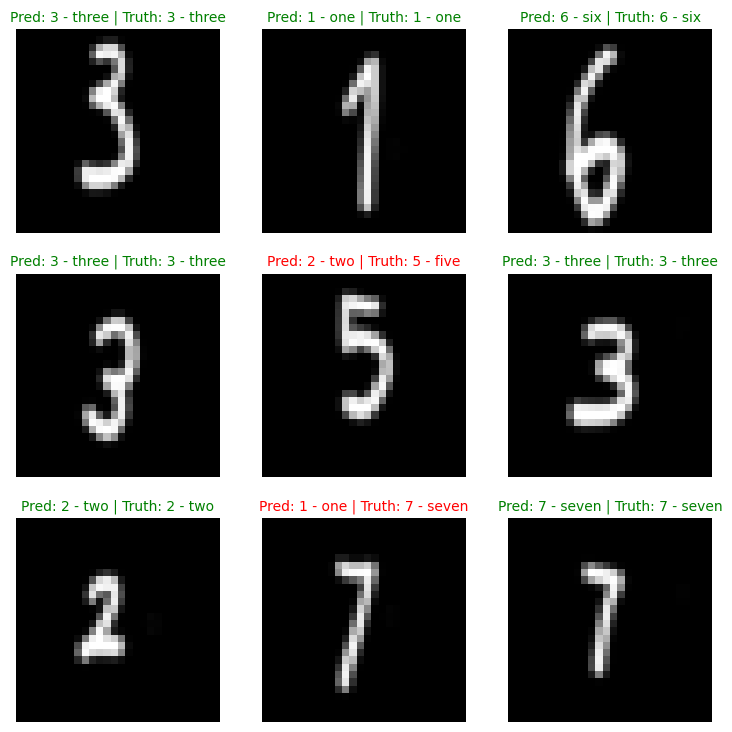

In [ ]:
# Plot predictions
plt.figure(figsize=(9, 9))
nrows = 3
ncols = 3
for i, sample in enumerate(random_custom_samples):
  # Create a subplot
  plt.subplot(nrows, ncols, i+1)

  # Plot the target image
  plt.imshow(sample.squeeze(), cmap="gray")

  # Find the prediction label (in text form, e.g. "1 - one")
  pred_label = class_names[random_custom_pred_classes[i]]

  # Get the truth label (in text form, e.g. "1 - one")
  truth_label = class_names[random_custom_labels[i]]

  # Create the title text of the plot
  title_text = f"Pred: {pred_label} | Truth: {truth_label}"

  # Check for equality and change title colour accordingly
  if pred_label == truth_label:
      plt.title(title_text, fontsize=10, c="g") # green text if correct
  else:
      plt.title(title_text, fontsize=10, c="r") # red text if wrong
  plt.axis(False);

Como podemos ver nuestro modelo acertó en 7 de 9 imagenes descargadas, lo cual es bastante aceptable.

#EVALUACIÓN DEL MODELO CON CUSTOM DATASET

Como etapa final, se realizan predicciones para todas las imagenes descargadas. A fin de poder calcular la precisión que obtiene el modelo con este set de datos desconocido.
Primeramente se extraen las clases correspondientes a cada imagen a fin de compararlas posteriormente con las clases inferidas por el modelo.

In [ ]:
#Create empty list for samples and labels
custom_samples = []
custom_labels = []
#Get the samples and labels data using for loop
for sample, label in list(custom_data):
    custom_samples.append(sample)
    custom_labels.append(label)

In [ ]:
#Print custom labels
print(custom_labels)

[7, 7, 7, 7, 7, 5, 5, 5, 5, 5, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 6, 6, 6, 6, 6, 9, 9, 9, 9, 9, 8, 8, 8, 8, 8, 0, 0, 0, 0, 0]


In [ ]:
#Tranform list of custom labels into tensor
torch.Tensor(custom_labels)

tensor([7., 7., 7., 7., 7., 5., 5., 5., 5., 5., 4., 4., 4., 4., 4., 3., 3., 3.,
        3., 3., 2., 2., 2., 2., 2., 1., 1., 1., 1., 1., 6., 6., 6., 6., 6., 9.,
        9., 9., 9., 9., 8., 8., 8., 8., 8., 0., 0., 0., 0., 0.])

Se realiza la predicción de clases del dataset creado anteriormente.

In [ ]:
#Make predictions with trained model
y_preds = []
model_0.eval()
with torch.inference_mode():
  for X, y in tqdm(custom_dataloader, desc="Making predictions"):
    # Send data and targets to target device
    X, y = X.to(device), y.to(device)
    # Do the forward pass
    y_logit = model_0(X)
    # Turn predictions from logits -> prediction probabilities -> predictions labels
    y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1) # note: perform softmax on the "logits" dimension, not "batch" dimension (in this case we have a batch size of 32, so can perform on dim=1)
    # Put predictions on CPU for evaluation
    y_preds.append(y_pred.cpu())
# Concatenate list of predictions into a tensor
custom_pred_tensor = torch.cat(y_preds)

Making predictions:   0%|          | 0/2 [00:00<?, ?it/s]

Observamos que numeros detectecto nuestro modelo para el set de datos descargados que se paso.

In [ ]:
#Let's see predicted classes tensor
custom_pred_tensor

tensor([7, 1, 7, 7, 7, 2, 5, 5, 5, 5, 7, 4, 4, 4, 4, 3, 3, 3, 3, 3, 2, 2, 2, 2,
        2, 1, 1, 1, 1, 1, 6, 6, 6, 8, 5, 9, 9, 9, 8, 1, 8, 8, 8, 8, 8, 0, 9, 5,
        9, 0])

En este caso nuestro modelo acerto un 80% de las veces. Lo cual es un resultado aceptable. Ya que es un modelo simple, liviano y rapido; ademas de que este nuevo set de datos era diferente al set utilizado para prueba y testeo. Pudiendose realizar mejoras a futuro para equiparar este resultado con los obtenidos usando el dataset MNIST.

In [ ]:
#Calculate accuracy with custom data
score_custom_data = accuracy_score(torch.Tensor(custom_labels), custom_pred_tensor)
score_custom_data

0.8

Por último se agrega una matriz de confusión para poder visualizar en que clases fue mas robusto el modelo con el set de datos descargado.

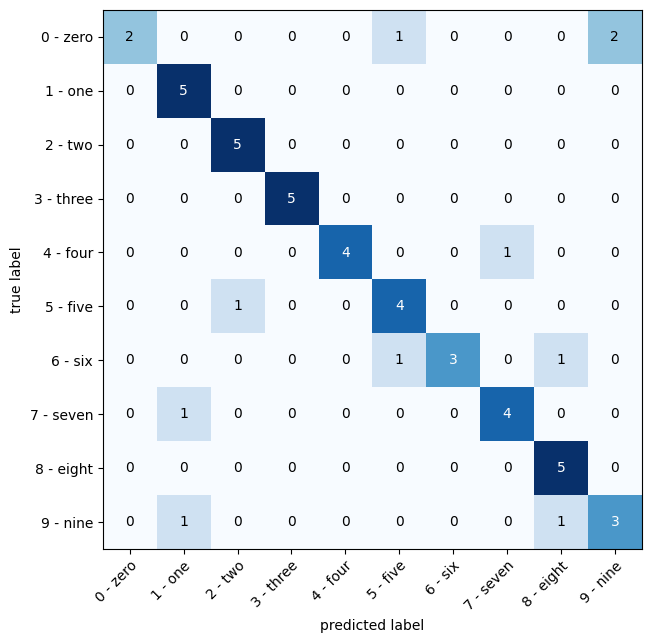

In [ ]:
#Create confusion matrix for our custom data
confmat = ConfusionMatrix(num_classes=len(class_names), task='multiclass')
confmat_tensor = confmat(preds=custom_pred_tensor,
                         target=torch.Tensor(custom_labels))

fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(), # matplotlib likes working with NumPy
    class_names=class_names, # turn the row and column labels into class names
    figsize=(10, 7) #define
);

# CONCLUSIÓN

El presente trabajo buscó la creación de un modelo capaz de detectar numeros a partir de imagenes; presento dos etapas separadas cada una con sus desafíos, los cuales se fueron abordando a lo largo de todo el recorrido. Pudiendo conseguir los objetivos propuestos, realizando un analisis y descripción de cada etapa para una mejor comprensión.
Permitiendo poder ser base para otros trabajos similares, ya que por su confección el código implementado sirve a su vez como guía.
Obteniendo resultados satisfactorios de precisión, tiempo de ejecución y peso queda resuelta la actividad propuesta.